In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from pathlib import Path
import warnings

warnings.filterwarnings('ignore') #supress warnings
sns.set(style='darkgrid') # set theme for plotting
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# WE WILL DO THE FOLLOWING THINGS IN ORDER
- Brief overview of the dataset
- Data Cleaning
- EDA
- Feature engineering
- spliting into train, validation dataset
- Missing Values
- Feature Selection
- Preprocessing
- establish a baseline model
- find the best models
- use the best models to make prediction

****EDA, Feature Engineering or Missing values these three steps depends on person to person and project depended.****
****Normally you would do data cleaning for small dataset like these on spreadsheet but we will do data cleaning in python whenever we spot any unusal values or problems****

# DATASET OVERVIEW

In [ ]:
# loading dataset

path = Path('../input/predict-loan-amount-data/')

train = pd.read_csv(path / 'train.csv')
test = pd.read_csv(path / 'test.csv')

train.head()

Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56    1933.05000              Low   
1     C-33999  America Calderone      M   32    4952.91000              Low   
2      C-3770      Rosetta Verne      F   65     988.19000             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31    2614.77000              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                72809.58000   
1    Working                    NaN  Semi-Urban                46837.47000   
2  Pensioner                    NaN  Semi-Urban                45593.04000   
3  Pensioner                    NaN       Rural                80057.92000   
4    Working  High skill tech staff  Semi-Urban               113858.89000   

   ...  Credit Score No. of Defaults Has Active Credit Card  Property ID  \
0  ...     809.44000               0                    NaN          746   
1  ...     780.40000               0            Unpossessed          608   
2  ...     833.15000               0            Unpossessed          546   
3  ...     832.70000               1            Unpossessed          890   
4  ...     745.55000               1                 Active          715   

   Property Age  Property Type Property Location  Co-Applicant  \
0    1933.05000              4             Rural             1   
1    4952.91000              2             Rural             1   
2     988.19000              2             Urban             0   
3           NaN              2        Semi-Urban             1   
4    2614.77000              4        Semi-Urban             1   

   Property Price  Loan Sanction Amount (USD)  
0    119933.46000                 54607.18000  
1     54791.00000                 37469.98000  
2     72440.58000                 36474.43000  
3    121441.51000                 56040.54000  
4    208567.91000                 74008.28000  

[5 rows x 24 columns]

In [ ]:
# cheking the datasets shape
train_rows, train_cols = train.shape[0], train.shape[1]
test_rows, test_cols = test.shape[0], test.shape[1]
  

print(f"The training dataframe has {train_rows} rows and {train_cols} cols")
print(f"The training dataframe has {test_rows} rows and {test_cols} cols")

The training dataframe has 30000 rows and 24 cols
The training dataframe has 20000 rows and 23 cols


In [ ]:
# data types
print("TRAINING SET:\n")
display(train.dtypes)

print("\nTEST SET: \n")
display(test.dtypes)

TRAINING SET:



Customer ID                     object
Name                            object
Gender                          object
Age                              int64
Income (USD)                   float64
Income Stability                object
Profession                      object
Type of Employment              object
Location                        object
Loan Amount Request (USD)      float64
Current Loan Expenses (USD)    float64
Expense Type 1                  object
Expense Type 2                  object
Dependents                     float64
Credit Score                   float64
No. of Defaults                  int64
Has Active Credit Card          object
Property ID                      int64
Property Age                   float64
Property Type                    int64
Property Location               object
Co-Applicant                     int64
Property Price                 float64
Loan Sanction Amount (USD)     float64
dtype: object


TEST SET: 



Customer ID                     object
Name                            object
Gender                          object
Age                              int64
Income (USD)                   float64
Income Stability                object
Profession                      object
Type of Employment              object
Location                        object
Loan Amount Request (USD)      float64
Current Loan Expenses (USD)    float64
Expense Type 1                  object
Expense Type 2                  object
Dependents                     float64
Credit Score                   float64
No. of Defaults                  int64
Has Active Credit Card          object
Property ID                      int64
Property Age                   float64
Property Type                    int64
Property Location               object
Co-Applicant                    object
Property Price                  object
dtype: object

In [ ]:
# mismatches data types
for col in train.columns:
    if col == 'Loan Sanction Amount (USD)':
        continue
        
    train_dtype = train[col].dtype
    test_dtype = test[col].dtype
    
    if train_dtype != test_dtype:
        print(col)

Co-Applicant
Property Price


some data types in test set does not match with the training dataset like-
* Co-Applicant, Property Price

or what they actually contain like -
* Property Type(contain integar values while it is actually categorical feataure)

In [ ]:
# missing values
print('TRAINING SET MISSING VALUES: \n')
display(train.isnull().sum().sort_values(ascending=False))

print('\nTEST SET MISSING VALUES: \n')
display(test.isnull().sum().sort_values(ascending=False))

TRAINING SET MISSING VALUES: 



Type of Employment             7270
Property Age                   4850
Income (USD)                   4576
Dependents                     2493
Credit Score                   1703
Income Stability               1683
Has Active Credit Card         1566
Property Location               356
Loan Sanction Amount (USD)      340
Current Loan Expenses (USD)     172
Gender                           53
Property Price                    0
Co-Applicant                      0
Property Type                     0
Property ID                       0
Customer ID                       0
No. of Defaults                   0
Name                              0
Expense Type 1                    0
Loan Amount Request (USD)         0
Location                          0
Profession                        0
Age                               0
Expense Type 2                    0
dtype: int64


TEST SET MISSING VALUES: 



Type of Employment             4689
Dependents                     1142
Has Active Credit Card         1076
Property Age                    892
Income Stability                813
Income (USD)                    750
Credit Score                    743
Property Location               160
Current Loan Expenses (USD)      83
Gender                           31
Customer ID                       0
No. of Defaults                   0
Co-Applicant                      0
Property Type                     0
Property ID                       0
Expense Type 1                    0
Expense Type 2                    0
Name                              0
Loan Amount Request (USD)         0
Location                          0
Profession                        0
Age                               0
Property Price                    0
dtype: int64

In [ ]:
train_cells, test_cells = (train_rows * train_cols), (test_rows * test_cols)
train_missing = train.isnull().sum().sum()
test_missing = test.isnull().sum().sum()

print(f"Missing values in train set {round((train_missing / train_cells) * 100, 3)}%")
print(f"Missing values in train set {round((test_missing / test_cells) * 100, 3)}%")

Missing values in train set 3.481%
Missing values in train set 2.256%


Not all columns has null values and percentage of null values are also low in train and test set

****checking for duplicates****

In [ ]:
#  checking for duplicated rows 
train.duplicated(keep=False).sum()

0

In [ ]:
train_duplicates = train.duplicated(subset=['Customer ID'], keep='first')
test_duplicates = test.duplicated(subset=['Customer ID'], keep='first')

print(f'There are {train_duplicates.sum()} is the training dataset')
print(f'There are {test_duplicates.sum()} is the test dataset')

There are 0 is the training dataset
There are 0 is the test dataset


****checking cardiniality****
<br>Generally too many cardiniality(unique values) in a feature is not good for making predictions as too many unique category means less examples for each unique value. So models can not learn from each category. Moreover if we use a feature with high cardinality and one hot encode it there would be too many new features created

In [ ]:
train.nunique().sort_values(ascending=False)

Customer ID                    30000
Name                           30000
Loan Amount Request (USD)      29982
Property Price                 29632
Income (USD)                   24429
Property Age                   24179
Current Loan Expenses (USD)    24041
Loan Sanction Amount (USD)     21450
Credit Score                   17586
Property ID                      999
Age                               48
Type of Employment                18
Dependents                        10
Profession                         8
Property Type                      4
Location                           3
Has Active Credit Card             3
Property Location                  3
Co-Applicant                       3
Expense Type 1                     2
Income Stability                   2
No. of Defaults                    2
Gender                             2
Expense Type 2                     2
dtype: int64

Many feature has high cardinality which was to be accepted as the features with high cardianility are mostly contain unique and continous values

****INSIGTS:****
  * There are enough data for trianing with 30000 observation
  * Co-Applicant, Property Price, Property Type data types do not match with what type of values they actually contain
  * There are not not that many missing values with only 3.5 percent of overall values missing in training set
  * There are null values in target <b>Loan Sanction Amount</b> 
  * There are not duplicate rows in training dataset
  * Customer Id, Name can not be used to gain any information about target value as they contain unique values and can not be feature engineered to create new useful feature like we all already have Gender feature which could have been derieved from Name if Gender featrue was not already  present
  
****NOTES:****
  * Converty Co-Applicant, Property Price, Property Type to correct data type
  * Drop Name feature for now
  * Drop rows which has null in it's target values

# DATA CLEANING
We will identify the most common problems found in a dataset and solve them
* Searching for null values (completed in previous part)
* Mismatches Data types(completed in previous part)
* Misspelled words in columns values
* Mistyped values or unusual values
* Extra spaces 
* Duplicates
* In consistent date formats
* any other problems

#We start will cleaning based on the insights gained in ****DATASET OVERVIEW**** step

In [ ]:
columns = ['Property Price', 'Co-Applicant', 'Property Type']
test[columns].head()

Property Price Co-Applicant  Property Type
0       236644.5            1              2
1       142357.3            1              1
2      300991.24            1              1
3       125612.1            0              1
4       180908.0            1              4

Co-Applicant, Property Price are integar type values but they are object type one possible reason for it be that there are some string values in these column

In [ ]:
test['Co-Applicant'].unique()

array(['1', '0', '?'], dtype=object)

In [ ]:
test[test['Property Price'] == '?']['Property Price'].head()

22     ?
149    ?
356    ?
402    ?
403    ?
Name: Property Price, dtype: object

In [ ]:
# Property Price and Co-Applicant has ? 
# we need to replace wtih null first before converting them to int or float

test[['Property Price', 'Co-Applicant']] = test[['Property Price', 'Co-Applicant']].replace({"?": np.nan})
test[['Property Price', 'Co-Applicant']] = test[['Property Price', 'Co-Applicant']].astype('float')

In [ ]:
train['Property Type'].unique()

array([4, 2, 1, 3])

<p>It seems that although Property Type is actually nominal categorical feature (categorical fetaure whose values do not have any rank)  they are recorded as discrete quantitive feature. So we will converty them to nominal categorical feature</p>

In [ ]:
int_to_object = {1: "property_type_1", 2: "property_type_2", 3: "property_type_3", 
                 4: "Property_type_4"}

train['Property Type'].replace(int_to_object, inplace=True)
test['Property Type'].replace(int_to_object, inplace=True)

In the previous module we also found out that there are null values in target column which need to be removed

In [ ]:
train = train.dropna(subset=['Loan Sanction Amount (USD)'])

In [ ]:
# dropping Name column in train and test
train.drop(columns=["Name"], inplace=True)
test.drop(columns=["Name"], inplace=True)

****misspelled words****

In [ ]:
# checking if there are any misspelled words
columns = train.select_dtypes(include=['object']).columns

# for train
for col in columns:
    if col == "Customer ID":
        continue      
    print(f"For train {col} {train[col].unique()}")

print()
for col in columns:
    if col == "Customer ID":
        continue      
    print(f"For test {col} {test[col].unique()}")

For train Gender ['F' 'M' nan]
For train Income Stability ['Low' 'High' nan]
For train Profession ['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
For train Type of Employment ['Sales staff' nan 'High skill tech staff' 'Secretaries' 'Laborers'
 'Managers' 'Cooking staff' 'Core staff' 'Drivers' 'Realty agents'
 'Security staff' 'Accountants' 'Private service staff'
 'Waiters/barmen staff' 'Medicine staff' 'Cleaning staff'
 'Low-skill Laborers' 'HR staff' 'IT staff']
For train Location ['Semi-Urban' 'Rural' 'Urban']
For train Expense Type 1 ['N' 'Y']
For train Expense Type 2 ['N' 'Y']
For train Has Active Credit Card [nan 'Unpossessed' 'Active' 'Inactive']
For train Property Type ['Property_type_4' 'property_type_2' 'property_type_1' 'property_type_3']
For train Property Location ['Rural' 'Urban' 'Semi-Urban' nan]

For test Gender ['F' 'M' nan]
For test Income Stability ['Low' 'High' nan]
For test Profession ['Commerci

There doesn't appear to be any misspelled word

****mistyped numbers****

To make it simple we will only check the range of the continous features

In [ ]:
columns = train.select_dtypes(include=['float', int]).columns

# for train
for col in columns:
    max = train[col].max()
    min = train[col].min()
    print(f"For train feature {col} range is [{min} to {max}]")
   
print()
# for test
for col in columns:
    if col == "Loan Sanction Amount (USD)":
        continue
    max = test[col].max()
    min = test[col].min()
    print(f"For test feature {col} range is [{min} to {max}]")

For train feature Age range is [18 to 65]
For train feature Income (USD) range is [377.7 to 1777460.21]
For train feature Loan Amount Request (USD) range is [6048.24 to 621497.82]
For train feature Current Loan Expenses (USD) range is [-999.0 to 3840.88]
For train feature Dependents range is [1.0 to 14.0]
For train feature Credit Score range is [580.0 to 896.26]
For train feature No. of Defaults range is [0 to 1]
For train feature Property ID range is [1 to 999]
For train feature Property Age range is [377.7 to 1777460.21]
For train feature Co-Applicant range is [-999 to 1]
For train feature Property Price range is [-999.0 to 1077966.73]
For train feature Loan Sanction Amount (USD) range is [-999.0 to 481907.32]

For test feature Age range is [18 to 65]
For test feature Income (USD) range is [368.59 to 30427.68]
For test feature Loan Amount Request (USD) range is [6185.48 to 576335.68]
For test feature Current Loan Expenses (USD) range is [41.37 to 3305.97]
For test feature Dependents 

It seems that although the range for test dataset fetures are okay. Some features in training date set show some unsual values 
* Current Loan Expenses (USD) - [-999.0 to 3840.88]
* Co-Applicant               - [-999 to 1]
* Property Price              - [-999.0 to 1077966.73]
* Loan Sanction Amount (USD)  - [-999.0 to 481907.32]


* Income (USD) & Property Age - [377.7 to 1777460.21] has same range in both train and test dataset which is very suspicious as they could be duplicat column


****Finding unusal values and outlayers part is still not completed as they sometimes pretty hard to find. So we will search for layers in EDA part with the help of visualization and clean them****

In [ ]:
train['Co-Applicant'].unique()

array([   1,    0, -999])

MY guess is that the -999 for first four features is probably a way of expressing null or a special value used only in that specific bank.

In [ ]:
vars = ['Property Price','Co-Applicant','Current Loan Expenses (USD)','Loan Sanction Amount (USD)']
(train[vars] == -999).sum()

Property Price                 341
Co-Applicant                   165
Current Loan Expenses (USD)    174
Loan Sanction Amount (USD)     338
dtype: int64

Normally we would have asked the dataset creator about what these -999 represnts but since we have no way of doing that and we have 30000 training data we will just remove them from the training set to avoid any problem that might arise for filling them in 

In [ ]:
index_to_keep = (train[vars] != -999).all(axis=1)
train = train.loc[index_to_keep]

In [ ]:
train.shape
# 28674, 23

(28674, 23)

The Income (USD) and Property Age has the same range lets look into that first

In [ ]:
train[['Income (USD)', 'Property Age']].head()

Income (USD)  Property Age
0    1933.05000    1933.05000
1    4952.91000    4952.91000
2     988.19000     988.19000
3           NaN           NaN
4    2614.77000    2614.77000

In [ ]:
train['Income (USD)'].equals(train['Property Age'])

False

It is telling us False which does not make sense since every values are equal. It could be due to null values

In [ ]:
train[['Income (USD)', 'Property Age']].isnull().sum()

Income (USD)    4256
Property Age    4513
dtype: int64

It seems that althouh values are equal Income has more null values

In [ ]:
(train['Income (USD)'] - train['Property Age']).sum()

0.0

Excluding the null values the two features are same

We can see that income (USD) and Property Age is actually same. Right now I would have questioned the authencity of the dataset but since the dataset came from machine learning competition it was probably done intentionally. Since the values does not look property Age it is probably Income (USD) values and Income (USD) has less null values. So we will drop Property Age for both training and test set to avoid any co-linearity

In [ ]:
train.drop('Property Age', axis=1, inplace=True)

****extra spaces****

In [ ]:
columns = train.select_dtypes(include=['object']).columns
train[columns].head(2)

Customer ID Gender Income Stability Profession Type of Employment  \
0     C-36995      F              Low    Working        Sales staff   
1     C-33999      M              Low    Working                NaN   

     Location Expense Type 1 Expense Type 2 Has Active Credit Card  \
0  Semi-Urban              N              N                    NaN   
1  Semi-Urban              N              Y            Unpossessed   

     Property Type Property Location  
0  Property_type_4             Rural  
1  property_type_2             Rural

In [ ]:
# remove repeated spaces in all of the columns in the dataframe
# here \s+ means that select all those who which has on or more white sapces
train[columns].replace("\s+", " ", regex=True, inplace=True)
test[columns].replace("\s+", " ", regex=True, inplace=True)

In [ ]:
# removeing leading and trailing white spaces
def remove_spaces(df, column):
    df[column] = df[column].str.strip()
    return df[column]
    
for col in columns:
    train[col] = remove_spaces(train, col)
    test[col] = remove_spaces(test, col)

****duplicates, Inconsistent data formats or anyother type of problem****

We have checked for duplicated rows in data overview part. Now will check for duplicated columns. But since we have already found duplicated columns while finding mistyped numbers we will skip these part. You can find how to find and remove duplicated columns in the article made by geeks for geeks below <a href=''>dsljf</a>

Since we do not have any date fetures in our dataset we will skip these part too and if any type of problem is found later we will fix them as we go through the project

****Even though our size of the training set has decreased from (30000, 23) to (28674, 22) we will get more accurate result and less hastle during the analyzing part.<br>Our dataset is still not fully cleared as we have missing values and probably outlayers which we will handle in the EDA and MISSING VALUES PART throught visualization****

In [ ]:
train.shape

(28674, 22)

# EDA
* target feture analysis
* looking at continous categorical and gaining insight from them 

*****since in our case we need to do regression and classfication both we will analyze for each problem separetly. We start by analyzing for regression model first since it is easier to spot outliers that way*****

****analysing target variable****

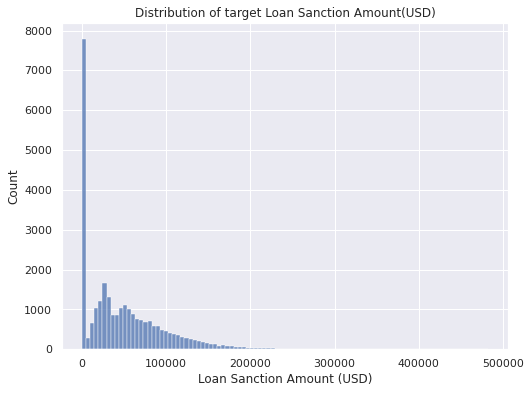

In [ ]:
plt.figure(figsize=(8, 6))

target = train['Loan Sanction Amount (USD)']
sns.histplot(x=target)
plt.title('Distribution of target Loan Sanction Amount(USD)')
plt.show()

<p>A lot of the target values are Zero which indicates that they were not given any loan. We should see how our target distribution looks without zero</p>

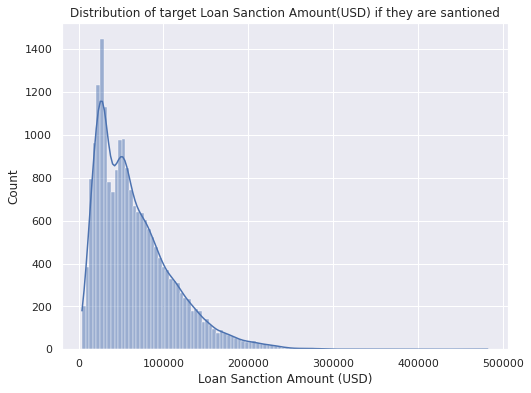

In [ ]:
plt.figure(figsize=(8, 6))

sns.histplot(x=target[target>0], kde=True)
plt.title('Distribution of target Loan Sanction Amount(USD) if they are santioned')
plt.show()

In [ ]:
target[target>0].describe()

count    20899.00000
mean     65929.41552
std      44896.39333
min       4023.18000
25%      30356.53500
50%      55177.65000
75%      89146.97000
max     481907.32000
Name: Loan Sanction Amount (USD), dtype: float64

In [ ]:
print(f"The target has a skewness of {target.skew()}")
print(f"The target has a peakedness of {target.kurtosis()}")

The target has a skewness of 1.2276852265205898
The target has a peakedness of 1.7688603413820507


Acceptable range for skewness -  (-3 to +3)<Br>
Acceptable range for kurtosis -  (-10 to +10)

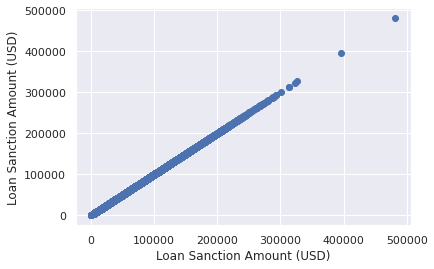

In [ ]:
# looking for outlayers
plt.scatter(target, target)
plt.xlabel('Loan Sanction Amount (USD)')
plt.ylabel('Loan Sanction Amount (USD)')
plt.show()

We can do power transformation to reduce the skewness using different transformation like log, box-cox or johnson transformation

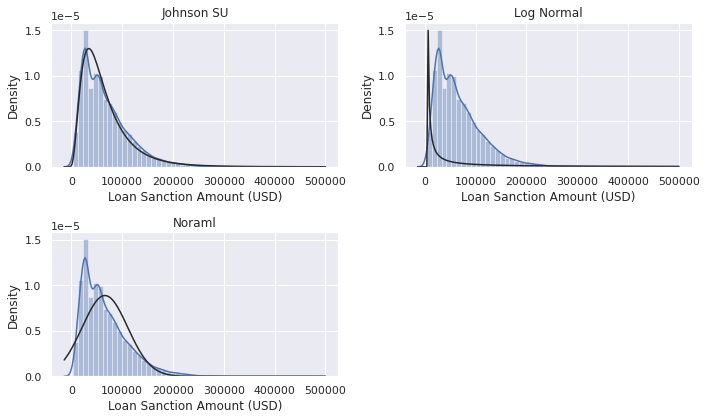

In [ ]:
# remvoing 0 values to do transformation
target_without_zero = target[target > 0]

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1);
sns.distplot(target_without_zero, fit=stats.johnsonsu)
plt.title('Johnson SU')

plt.subplot(2, 2, 2)
sns.distplot(target_without_zero, fit=stats.lognorm)
plt.title("Log Normal")

plt.subplot(2, 2, 3)
sns.distplot(target_without_zero, fit=stats.norm)
plt.title("Noraml")

plt.tight_layout()

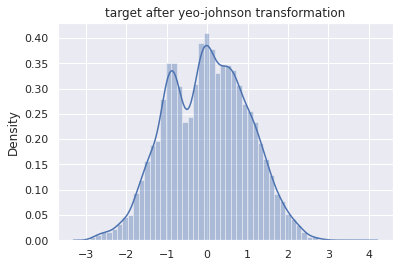

In [ ]:
target_transformed = pd.Series(PowerTransformer().fit_transform(target_without_zero.to_frame()).flatten())

sns.distplot(x= target_transformed)
plt.title("target after yeo-johnson transformation")
plt.show()

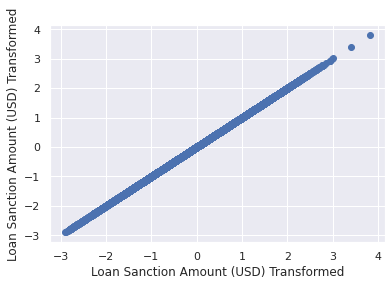

In [ ]:
plt.scatter(target_transformed, target_transformed)
plt.xlabel('Loan Sanction Amount (USD) Transformed')
plt.ylabel('Loan Sanction Amount (USD) Transformed')
plt.show()

In [ ]:
print(f"The target has a skewness of {target_transformed.skew()} after transformation")
print(f"The target has a peakedness of {target_transformed.kurtosis()} after transformation")

The target has a skewness of -0.02212240045783058 after transformation
The target has a peakedness of -0.48000818248513344 after transformation


****INSIGHTS:****
<BR>
* Target has a lot of zero values indicating no loan sanction 
* The target show some skewness and peakedness and does not follow normal distribution
* There are 2 unusally high values in target features
    
****NOTES:****
<BR>
* We can log transformation or Johnson Transformation on target to normalize it
* We can handle zero inflated target variable by creating two models where classification model will predict if the person will have loan sanctioned or not and regression model would predict loan amount if they were given loan sanction. To do this we will create a feature we will predict if someone was given sanction or not
    
Before doing anything else we will create a feature on loan santioned or not
  
<br>
    You can find more about hadling zero inflated target from the article <a href='https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af'>Zero-Inflated Regression</a> by <b>Dr. Robert Kübler</b>

In [ ]:
train['Loan Sanctioned'] = train['Loan Sanction Amount (USD)'] > 0

Loan Santioned feature target feature for classification and so we will anayliz it too

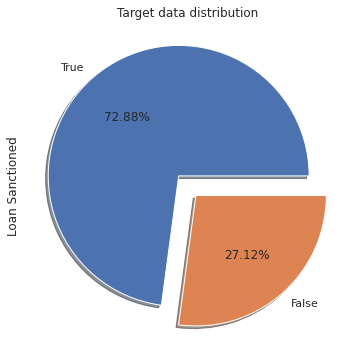

In [ ]:
plt.figure(figsize=(8, 6))

train['Loan Sanctioned'].value_counts().plot(kind='pie', explode=[0.1, 0.1], 
                                            autopct='%2.2f%%', shadow=True)

plt.title('Target data distribution')
plt.show()

****INSIGHTS:****
<BR>
* Loan Santioned target feature is not balanced

****NOTES:****
<br>    
* May need to use sampling method to increase accuracy like oversampling, undersamplig, smothing etc
    
We are done with analyzing target variables now we will analyze continous data and see their relationship with both of the target variables

<H4>ANALYZING CONTINOUS DATA</H4>

- see basic overview
- plot distribution
- look for outliers
- what kind of relation with target can we infer from the scatterplot

****basic overview****

In [ ]:
con_feats = train.select_dtypes(include=['float', 'int']).columns
info = ['min', 'max', 'mean', '50%', 'std']

print("Training sets overview: ")
display(train[con_feats].describe().loc[info])

Training sets overview: 


Age  Income (USD)  Loan Amount Request (USD)  \
min  18.00000     377.70000                 6048.24000   
max  65.00000 1777460.21000               621497.82000   
mean 40.12042    2633.19580                88842.82043   
50%  40.00000    2222.52000                75094.78500   
std  16.06254   11488.96023                59499.68400   

      Current Loan Expenses (USD)  Dependents  Credit Score  No. of Defaults  \
min                      33.76000     1.00000     580.85000          0.00000   
max                    3840.88000    14.00000     896.26000          1.00000   
mean                    409.23100     2.25410     740.06358          0.19394   
50%                     376.52000     2.00000     740.08500          0.00000   
std                     217.65967     0.95201      72.15044          0.39539   

      Property ID  Co-Applicant  Property Price  Loan Sanction Amount (USD)  
min       1.00000       0.00000      7265.95000                     0.00000  
max     999.00000       1.00000   1077966.73000                481907.32000  
mean    501.85262       0.85244    133294.28822                 48052.55127  
50%     504.00000       1.00000    111273.23000                 35842.39000  
std     288.12996       0.35466     92837.66828                 48251.10897

We can see that although mean and median are very close most of the time mean is generally greater than median indicating that there are outlayers present in training dataset feature

****Analyzing Features for Regression****


#analyzing continous variables

In [ ]:
 # dataset with only loan Santioned amount greater zero to help analyzing
train_greater_than_zero = train[train['Loan Sanction Amount (USD)'] > 0]

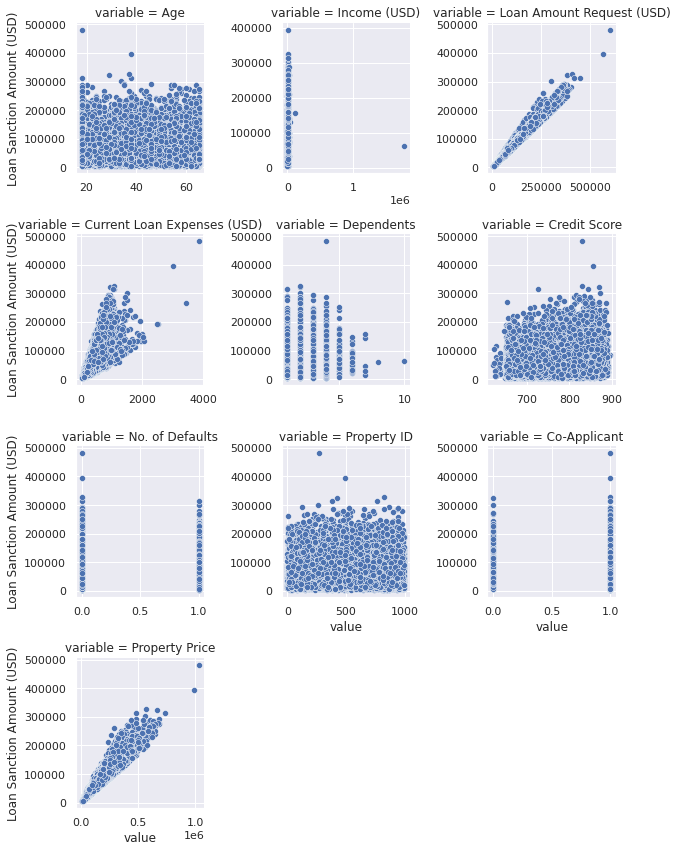

In [ ]:
f = train_greater_than_zero.melt(value_vars=con_feats, id_vars=['Loan Sanction Amount (USD)'])
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=3)
g.map(sns.scatterplot, 'value', 'Loan Sanction Amount (USD)')
plt.show()

We can easily spot some outlayers in some features like Income (USD), Current Loan Expenses, Dependents. We will remove them but before that we will need to fill in the null values for these features as with something as comparing something will null values will give us false. 

In [ ]:
out_vars = ['Income (USD)', 'Current Loan Expenses (USD)', 'Dependents']
train[out_vars] = train[out_vars].fillna(-1) # filling in nulls with -1

filt = ((train['Income (USD)'] < 18000) & (train['Current Loan Expenses (USD)'] < 2500) & 
      (train['Dependents'] < 10))              # filtering out outlayers


train = train[filt]                          # filtered dataframe
train.replace({-1: np.nan}, inplace=True)    # replacing -1 with previous null

In [ ]:
train_greater_than_zero=train[train['Loan Sanction Amount (USD)']>0] #updating traingreatetrhanzero

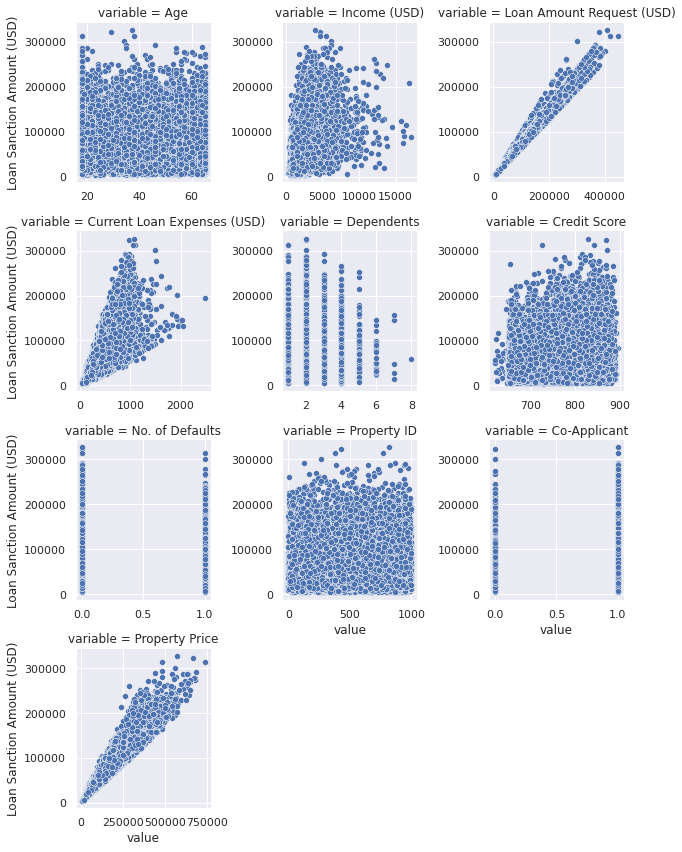

In [ ]:
# after cleaning
f = train_greater_than_zero.melt(value_vars=con_feats, id_vars=['Loan Sanction Amount (USD)'])
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=3)
g.map(sns.scatterplot, 'value', 'Loan Sanction Amount (USD)')
plt.show()

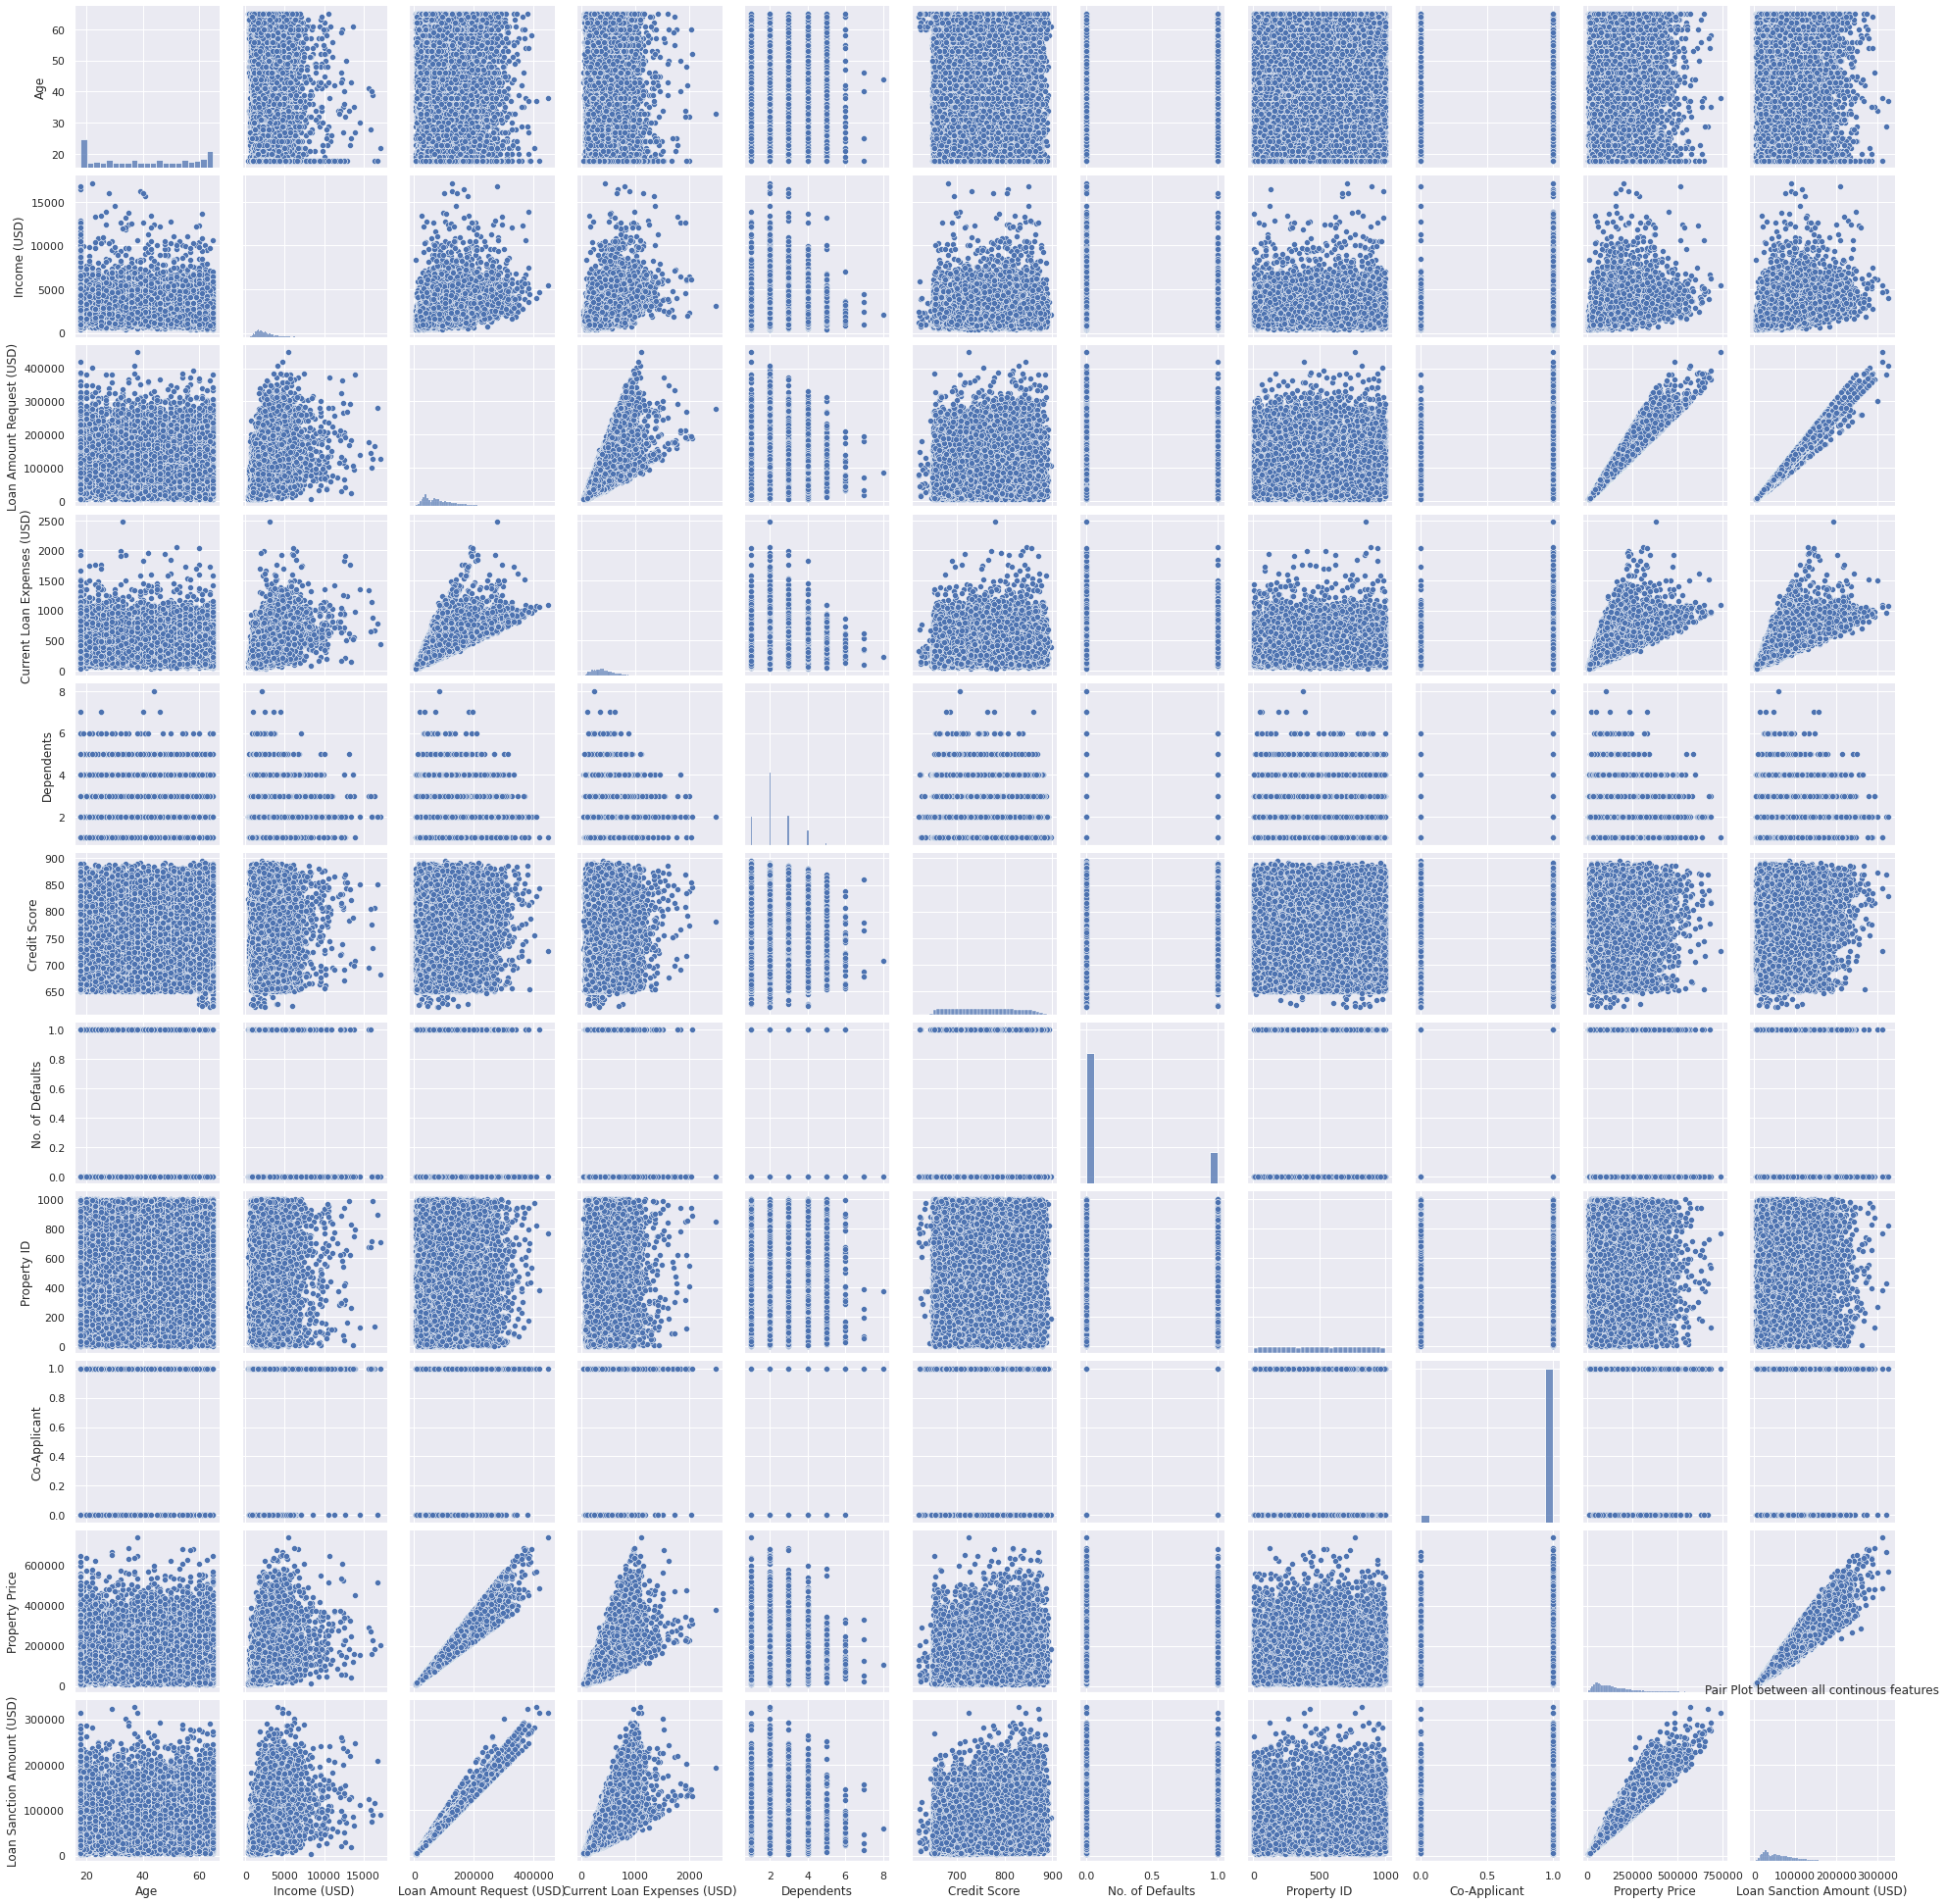

In [ ]:
# overview for all continous features
sns.pairplot(train_greater_than_zero[con_feats])
plt.title("Pair Plot between all continous features")
plt.show()

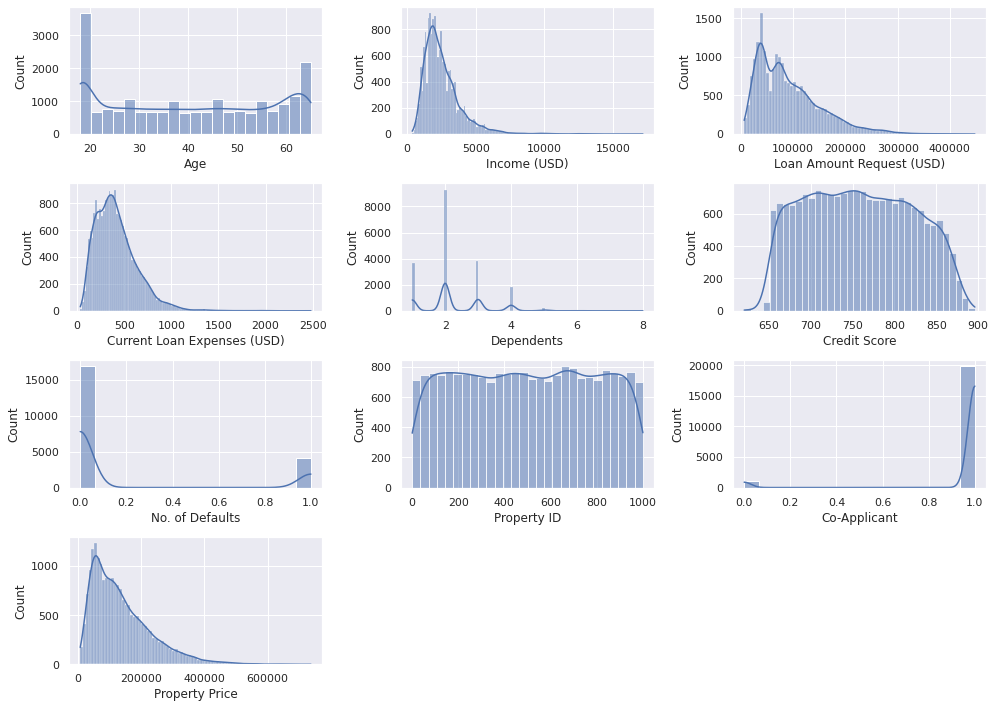

In [ ]:
# to see distribution
plt.figure(figsize=(14, 10))
for index, col in enumerate(con_feats):
    if col == 'Loan Sanction Amount (USD)':
        continue
    
    plt.subplot(4, 3, index+1)
    sns.histplot(train_greater_than_zero[col], kde=True)

    
plt.tight_layout()

****INSIGHTS:****
<br>
* There are some outlayers present in Income (USD), Current Loan Expenses (USD), Dependents
* Most continous values does not have a normal distribution
* Age surprising does not show any relation with target

****NOTES:****
<br>
* <strike>Remove outlayers</strike>
* Applying log or other transformation for normal distriubtion
* Try feature engineering on feature likes Age which surprisingly does not show any relationship
* Try different feature engineering techniques on different features like adding Income + Property Price to find the net worth

#analyzing categorical features

In [ ]:
# removing Customer ID for high cardianility 
# removing Loan Sanctioned(target) as it is derived from Loan Sanction Amont (target) and
# only contain one category in train_greate_than_zero
cat_feats=train.drop(columns=['Customer ID', 'Loan Sanctioned']).select_dtypes(include=['object']).columns
train_greater_than_zero[cat_feats].head()

Gender Income Stability Profession     Type of Employment    Location  \
0      F              Low    Working            Sales staff  Semi-Urban   
1      M              Low    Working                    NaN  Semi-Urban   
2      F             High  Pensioner                    NaN  Semi-Urban   
3      F             High  Pensioner                    NaN       Rural   
4      F              Low    Working  High skill tech staff  Semi-Urban   

  Expense Type 1 Expense Type 2 Has Active Credit Card    Property Type  \
0              N              N                    NaN  Property_type_4   
1              N              Y            Unpossessed  property_type_2   
2              N              Y            Unpossessed  property_type_2   
3              N              Y            Unpossessed  property_type_2   
4              N              Y                 Active  Property_type_4   

  Property Location  
0             Rural  
1             Rural  
2             Urban  
3        Semi-Urban  
4        Semi-Urban

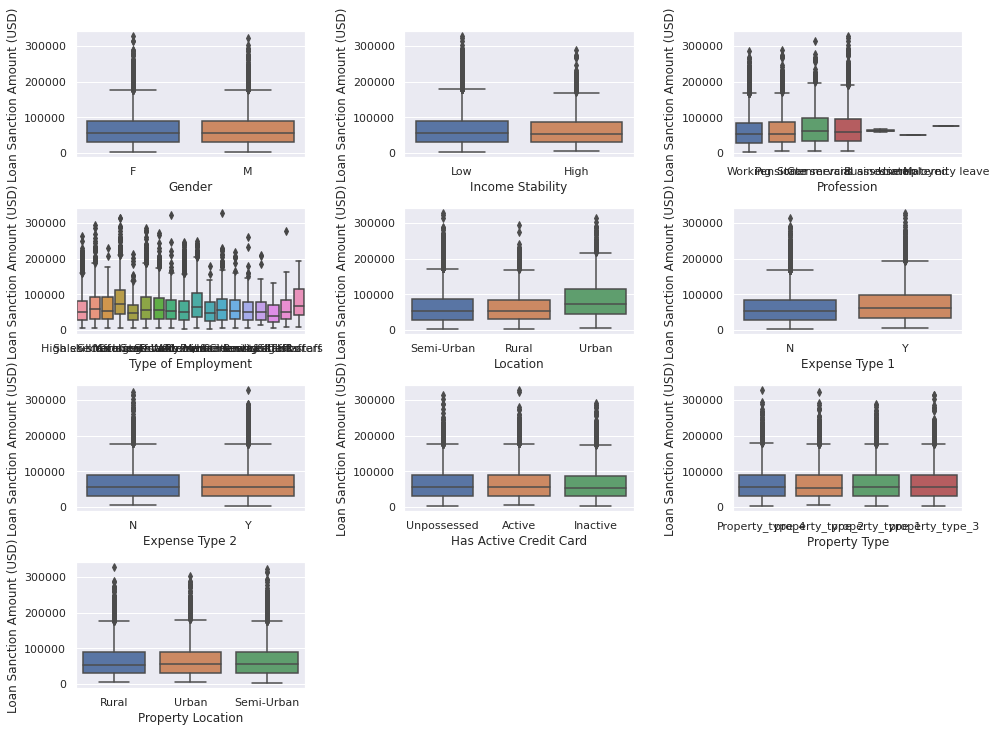

In [ ]:
plt.figure(figsize=(14, 10))
for index, col in enumerate(cat_feats):
    plt.subplot(4, 3, index+1)
    sns.boxplot(x=col, y='Loan Sanction Amount (USD)', data=train_greater_than_zero)
    
plt.tight_layout()

The Profession feature looks weird lets check that out

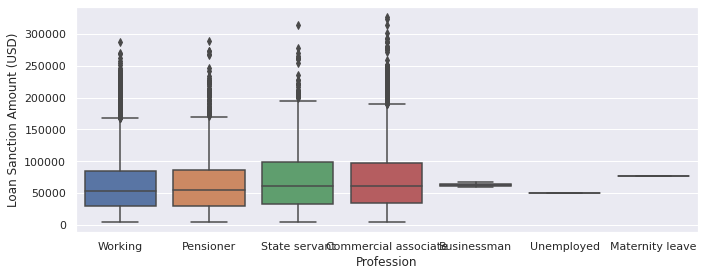

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Profession', y='Loan Sanction Amount (USD)', data=train_greater_than_zero)
plt.tight_layout()

In [ ]:
train_greater_than_zero['Profession'].value_counts()

Working                 11303
Commercial associate     5595
Pensioner                2279
State servant            1700
Businessman                 2
Unemployed                  1
Maternity leave             1
Name: Profession, dtype: int64

Some categories in Profession has very few observation we need to do something about them<br>
Although we can see some features which can be useful to regression but they are hardly any difference visibable. I t is because box plot alone can not tell the whole picture about data. We can try violin plot

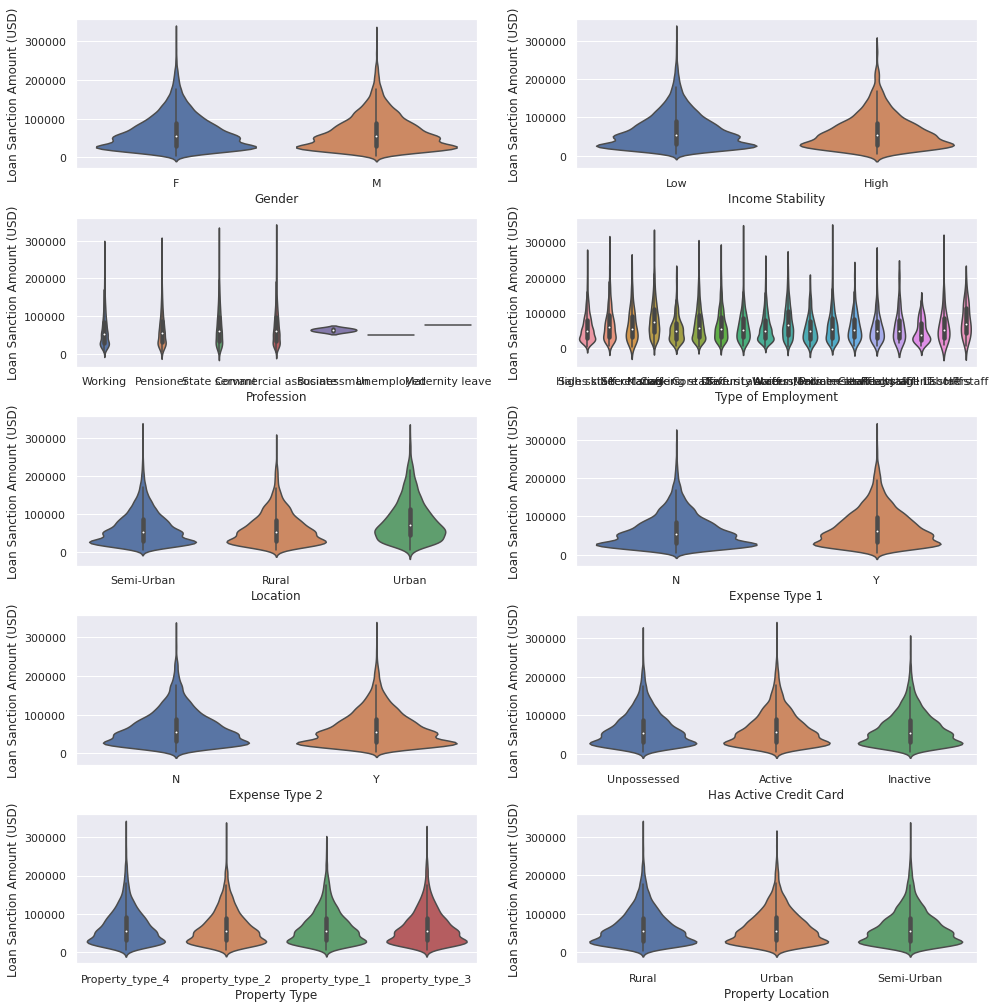

In [ ]:
plt.figure(figsize=(14, 14))
for index, col in enumerate(cat_feats):
    plt.subplot(5, 2, index+1)
    sns.violinplot(x=col, y='Loan Sanction Amount (USD)', data=train_greater_than_zero)
    
plt.tight_layout()

Even with violin plot it is hard to find useful features as every featrues categories has almost the same median and distribution or pdf. In simpler terms categories of a featrue can express variation of target feature meaning they are useless. 
But Profession, Types of Employment, Location, Expense Types 1 and 2 seems like useful feature

So to find useful feature we will use <b>ANOVA<b/>.<br>
To learn more about feature selection with anova you can check this article <a href='https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476'>ANOVA for Feature Selection in Machine Learning</a> by <b>Sampath Kumar Gajawada</b>.
Khan Academy's video on Anova is very good and can be found in youtube <a href=''> khan academy</a>

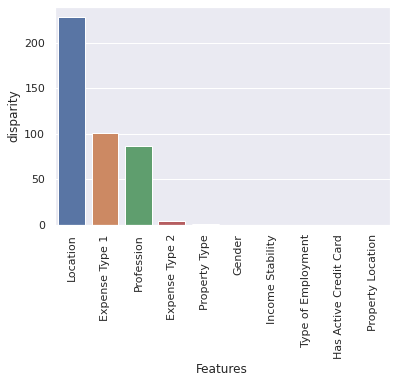

In [ ]:
def anova(frame):
    anv = pd.DataFrame()
    anv['Features'] = cat_feats
    pvals = []
    for feats in anv['Features']:
        samples = []
        for category in frame[feats].unique():
            s = frame[frame[feats] == category]['Loan Sanction Amount (USD)'].values
            samples.append(s)
            
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    
    anv['Pvals'] = pvals
    
    return anv.sort_values(by='Pvals')

a = anova(train_greater_than_zero)
a['disparity'] = np.log(1./a['Pvals'].values)
sns.barplot(data=a, x='Features', y='disparity')
plt.xticks(rotation=90)
plt.show()

Othe than Type of Employment Anova was able catch all those values which thought to be imporatnt

****INSIGHTS:****
<BR>
* Loan Sanction only has one categroy in train_greater_than_zero
* Most of the categorical features are  useless as they do not explain much variability in target feature other than Location, Expense Type, Profession, Type of Employment(was not able capture throught anova but was able identify from the violin) 
* Profession Feature has few categories which has observations less than 5.
    
****NOTES:****
<BR>
* Do not use CustomerId and Loan Santioned when doing regression
* Keep all other features even if they may appear useless
* Filter out the other categories which has less than 5 observation from Profession Feature or group them into one category Other
* Add two Expenses feature and make them one new feature since they are related

****For Classification****<br>
For classification we will analyze with a sample of the training set with equal amount True and False values in the target feature so that we can easily find realtion with other feature

In [ ]:
# we do not need Loan Sanction Amount (USD) which is a target feature  
train_clf = train.drop(columns=['Loan Sanction Amount (USD)'])

In [ ]:
train_clf['Loan Sanctioned'].value_counts()

True     20881
False     7769
Name: Loan Sanctioned, dtype: int64

In [ ]:
false_count = train_clf['Loan Sanctioned'].value_counts()[False]
train_true_sample = train_clf[train_clf['Loan Sanctioned'] == True].sample(false_count)
train_false_sample = train_clf[train_clf['Loan Sanctioned'] == False]

train_clf_sample = pd.concat([train_true_sample, train_false_sample])
train_clf_sample['Loan Sanctioned'].value_counts()

True     7769
False    7769
Name: Loan Sanctioned, dtype: int64

#analyzing categorical features

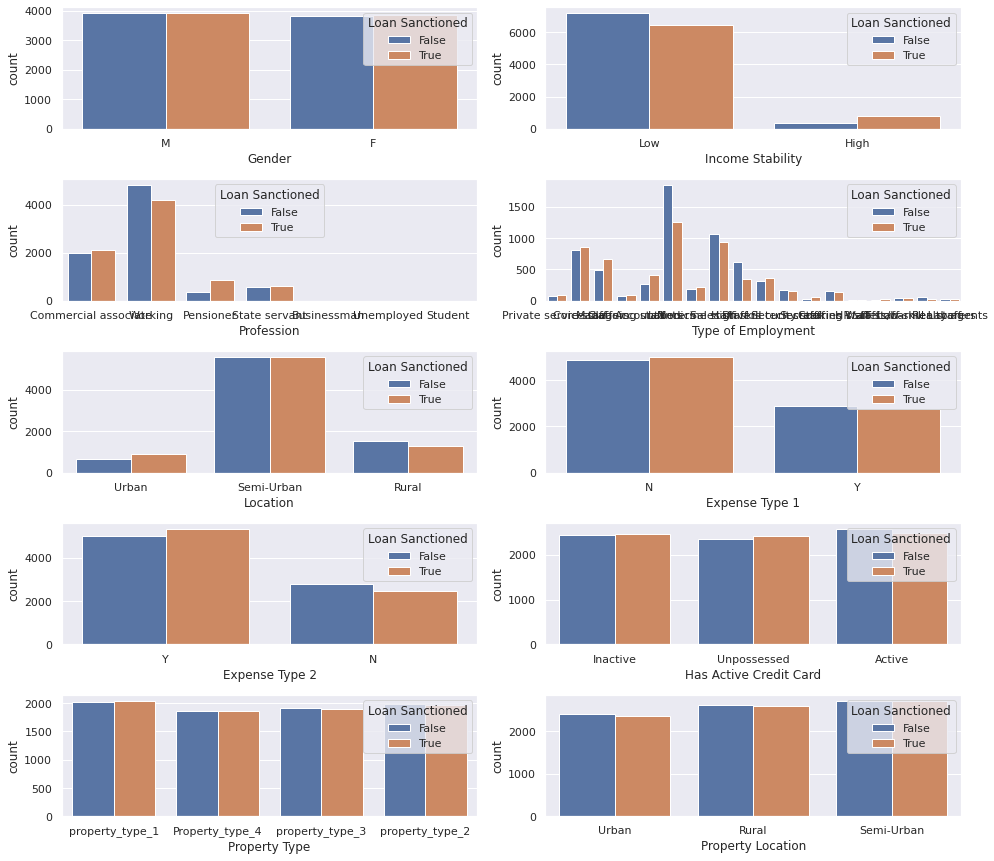

In [ ]:
plt.figure(figsize=(14, 14))
lenged = True
for index, col in enumerate(cat_feats):
    if col == 'Loan Santioned':
        continue
    plt.subplot(6, 2, index+1)
    sns.countplot(x=col, hue='Loan Sanctioned', data=train_clf_sample)


    
plt.tight_layout()

****INSIGHTS:****
<Br>
* Stability, Profession, Type of Employment, Location, Expense Type, Property Location has an impact on Getting Loan
* Income Stability although a important featurer has very unbalanced data
* Gender, Property Location does not have impact on target

****NOTES****
* Location can converted to orderly categorical data


#analyzing continous features

In [ ]:
con_feats = train_clf_sample.select_dtypes(include=['float', 'int']).columns

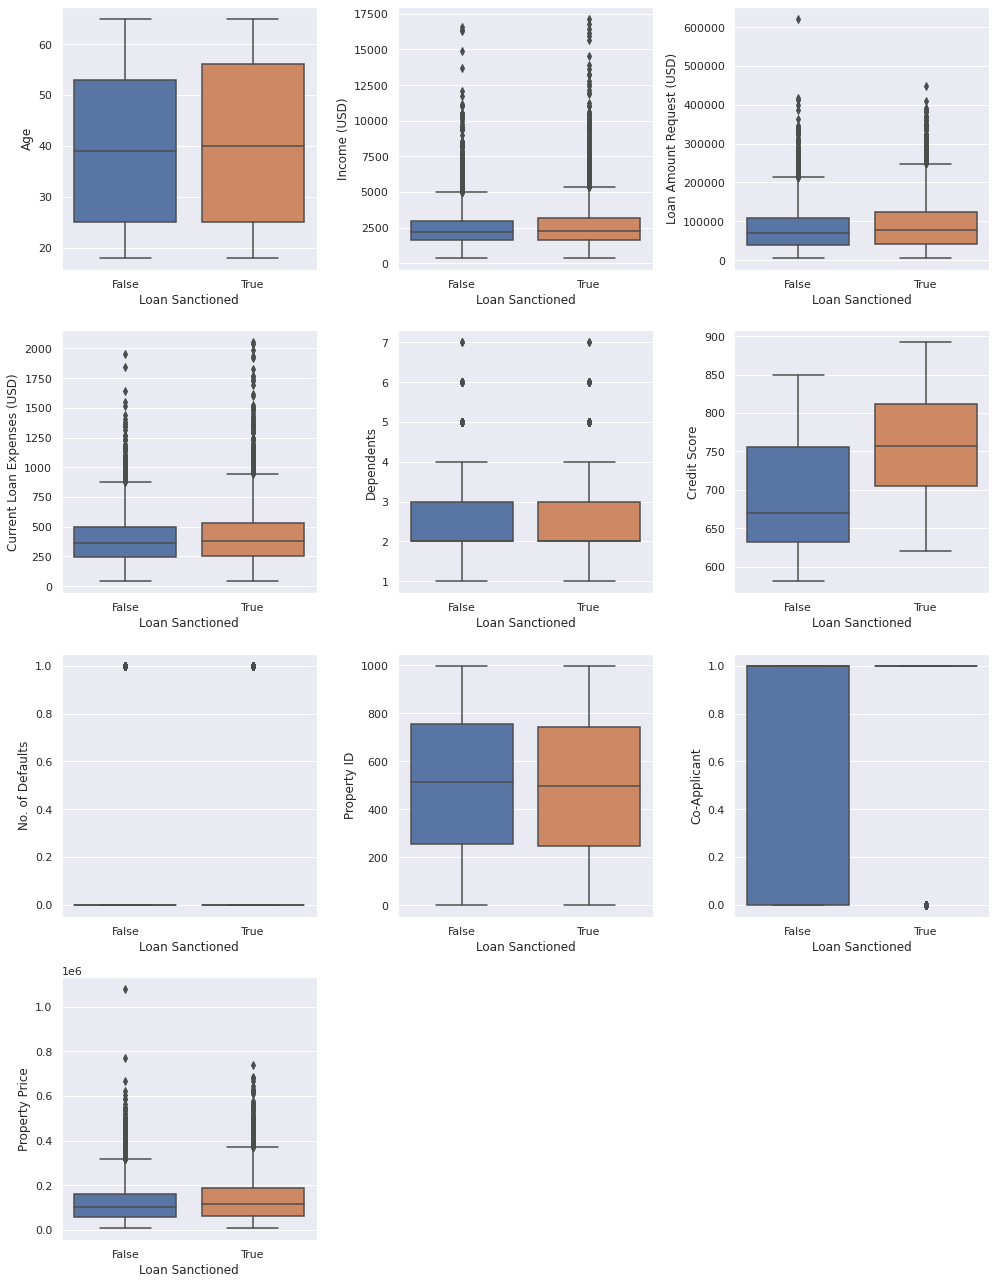

In [ ]:
plt.figure(figsize=(14, 18))
for index, col in enumerate(con_feats):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=col, x='Loan Sanctioned', data=train_clf_sample)

plt.tight_layout()

Lets plot violin plot next to see distribution too

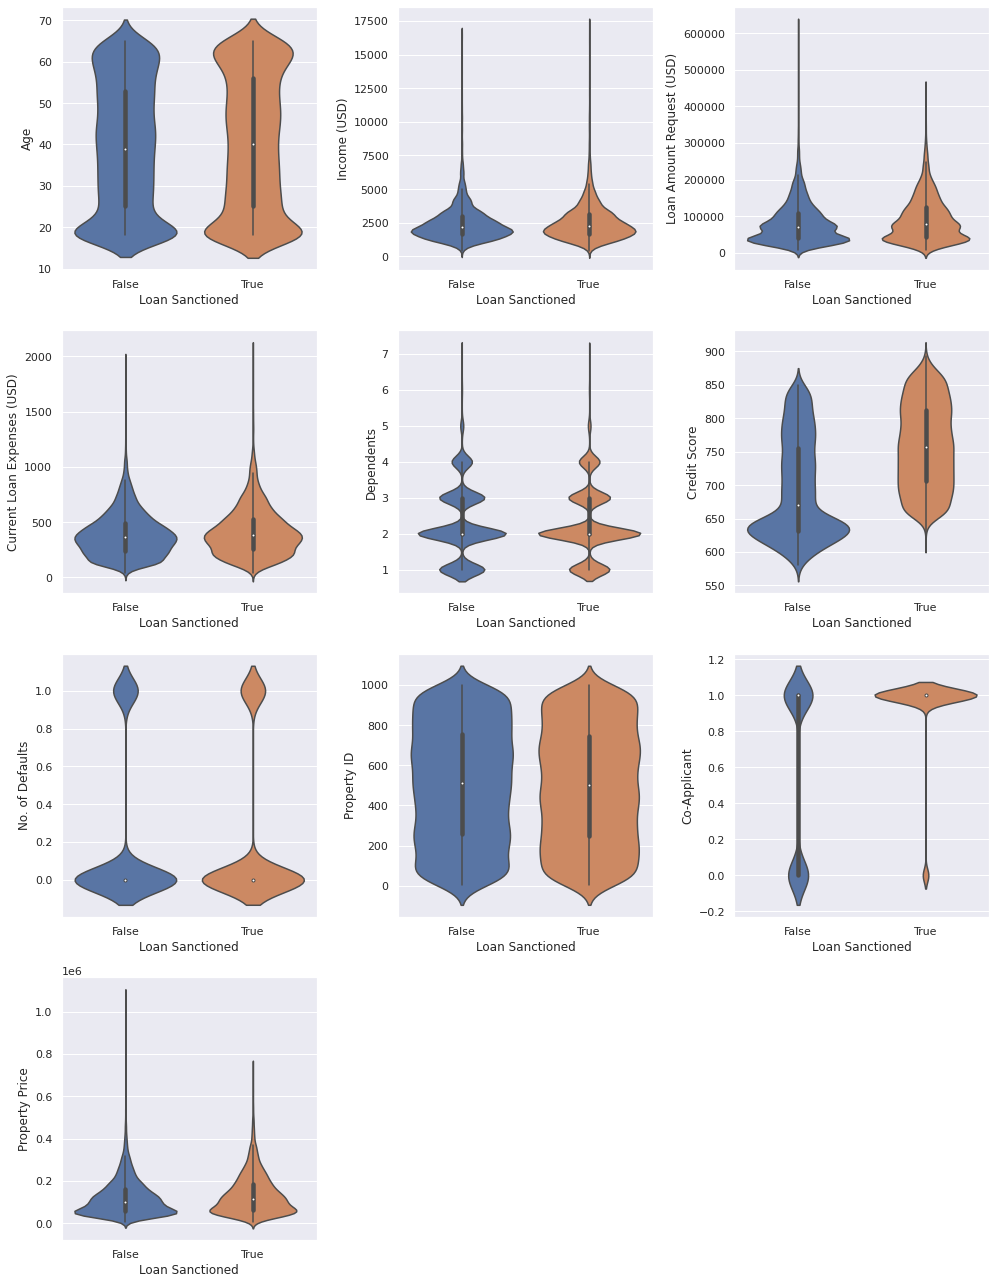

In [ ]:
plt.figure(figsize=(14, 18))
for index, col in enumerate(con_feats):
    plt.subplot(4, 3, index+1)
    sns.violinplot(y=col, x='Loan Sanctioned', data=train_clf_sample)

plt.tight_layout()

At a glance we can see at a glance that Credit Score is very important while other has minor impact on the result. There also some features with unbalanced data like Co-Applicant, No. of Defaults

In [ ]:
train_clf_sample['Co-Applicant'].max()

1

In [ ]:
co_app_count=pd.pivot_table(data=train_clf_sample, index='Co-Applicant', columns='Loan Sanctioned',
              values='Customer ID', aggfunc='count', margins=True)

<AxesSubplot:xlabel='Co-Applicant', ylabel='count'>

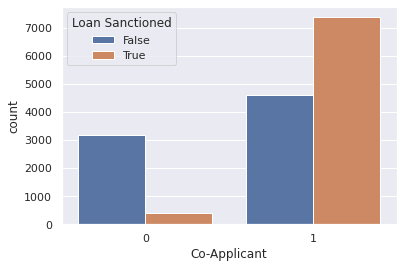

In [ ]:
i = train_clf_sample['Co-Applicant'].astype('object')

sns.countplot(x=i, hue=train_clf_sample['Loan Sanctioned'])

In [ ]:
co_app_count['False_perc'] = (co_app_count[False] / co_app_count['All']) * 100
co_app_count['True_perc'] = 100 - co_app_count['False_perc']
co_app_count

Loan Sanctioned  False  True    All  False_perc  True_perc
Co-Applicant                                              
0                 3183   400   3583    88.83617   11.16383
1                 4586  7369  11955    38.36052   61.63948
All               7769  7769  15538    50.00000   50.00000

In [ ]:
train_clf_sample['Co-Applicant'].value_counts()

1    11955
0     3583
Name: Co-Applicant, dtype: int64

In [ ]:
train_clf_sample.groupby(['Loan Sanctioned', 'Co-Applicant']).size()

In [ ]:
sns.countplot(x='Co-Applicant', hue='Loan Sanctioned', data=train_clf_sample)
plt.show()

It seems Co-Applicant is a very useful feature

In [ ]:
train_clf_sample['No. of Defaults'].value_counts()

In [ ]:
sns.countplot(x='No. of Defaults', hue='Loan Sanctioned', data=train_clf_sample)
plt.show()

No of Defaults does not seem to be very useful feature

In [ ]:
legend = False
plt.figure(figsize=(14, 18))
for index, col in enumerate(con_feats):
    if index == 1:
        legend = False
    plt.subplot(7, 2, index+1)
    sns.histplot(x=col, hue='Loan Sanctioned', data=train_clf_sample, legend=legend)

    
plt.tight_layout()

In [ ]:
var = 'Property Price'
plt.figure(figsize=(8, 4))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, legend=legend)
plt.show()

In [ ]:
var = 'Current Loan Expenses (USD)'

plt.figure(figsize=(8, 4))
sns.histplot(x=var, hue='Loan Sanctioned', data=train_clf_sample, legend=legend)
plt.show()

In [ ]:
var = 'Loan Amount Request (USD)'
plt.figure(figsize=(8, 4))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, legend=legend)
plt.show()

In [ ]:
x = train_clf_sample['Income (USD)']
hue = train_clf_sample['Loan Sanctioned']
plt.figure(figsize=(10, 5))
sns.histplot(x=x, hue=hue)
plt.show()

In [ ]:
x = np.log(train_clf_sample['Income (USD)'])
hue = train_clf_sample['Loan Sanctioned']
plt.figure(figsize=(12, 6))
sns.histplot(x=x, hue=hue)
plt.show()

****NOTES:****
<br>
* More credits, Co-Applicants has greater chances of having Loan Sanctioned
* Loan Amount Requested, Current Loan Expenses, Property Price impacts the target value when they cross certain threshold
* Those who have co-applicants has more chances of getting loans

****INSIGHTS:****
<br>
* Create new feature from credits, Co-Applicants, Loan Amount Requested, Current Loan Expenses, Property Price by converting them to categorcial feature 
* Log transform Income (USD) and convert it to categorical feature

<h3>Feature Engineering</h3>

In [ ]:
# converting Property Type from ordnial to nominal and one hot encoding
var = 'Property Type'

# converting from 1,2,3,4 to property_1, property_2, ...... and droppint last category
train_property_encoded=pd.get_dummies(train[var].astype('object'),prefix='Property_',drop_first=False)
test_property_encoded=pd.get_dummies(test[var].astype('object'),prefix='Property_',drop_first=False)

# dropping Property Type as we do not need it anymore
train.drop(columns=['Property Type'], inplace=True)
test.drop(columns=['Property Type'], inplace=True)

# joining one hot encoded values to 
train = train.join(train_property_encoded)
test = test.join(test_property_encoded)

In [ ]:
test['Profession'].value_counts()

In [ ]:
train['Profession'].value_counts()

adding othere category for all categories less than. We will not add train and test together to avoid data leakage

In [ ]:
var = 'Profession'
# grouping by Profession and counting each profession and if each category has less than 5 observation
# we will return them as other
train[var] = train.groupby(var)[var].transform(lambda x: x if x.count()> 5 else "Other")
test[var] = test.groupby(var)[var].transform(lambda x: x if x.count()> 5 else "Other")

normally we will fit transform the train and use only transform(based on the values of train set) on test set without doing any calculaton on test set but since the categories and their counts are pretty much the same  in train and test we will compute them seperately while coming to the same answer if we were to do it in the hard and more complicated way

In [ ]:
# adding expenses

expense1 = train['Expense Type 1'].factorize()[0]
expense2 = train['Expense Type 2'].factorize()[0]

total_expenses = pd.Series(expense1 + expense2)
train['Total Expenses'] = total_expenses

sns.boxplot(x='Total Expenses', y='Loan Sanction Amount (USD)', data=train)

In [ ]:
train['Expense Type 1'].value_counts()

In [ ]:
 train_greater_than_zero['Expense Type 1'].value_counts()

In [ ]:
i = train_greater_than_zero[train_greater_than_zero['Expense Type 1'] == 'N'].sample(7609)
j = train_greater_than_zero[train_greater_than_zero['Expense Type 1'] == 'Y'].sample(7609)
print(i['Loan Sanction Amount (USD)'].mean())
j['Loan Sanction Amount (USD)'].mean()

In [ ]:
i = train[train['Expense Type 1'] == 'N'].sample(10538)
j = train[train['Expense Type 1'] == 'Y']

i = pd.concat([i, j])

sns.histplot(hue='Expense Type 2', x='Loan Sanction Amount (USD)', data=i, palette=['red', 'green'])

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(hue='Expense Type 2', x='Loan Sanction Amount (USD)', data=train_greater_than_zero, palette=['red', 'green'])

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(hue='Expense Type 2', x='Loan Sanction Amount (USD)', data=train_greater_than_zero, palette=['red', 'green'])

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(hue='Total Expenses', x='Loan Sanction Amount (USD)', data=train, palette=['red', 'green', 'blue'])

In [ ]:
stats.f_oneway()

In [ ]:
train['Expense Type 1'].shape

In [ ]:
expense1 = train[train['Expense Type 1'] == 'N']['Loan Sanction Amount (USD)']
expense2 = train[train['Expense Type 1'] == 'Y']['Loan Sanction Amount (USD)']

In [ ]:
def get_variance(array):
    array_values = array.values
    mean = np.mean(array_values)

    
    var = (array_values - mean)**2
    return np.sum(var)

In [ ]:
sst = get_variance(train['Loan Sanction Amount (USD)'])
exp1_var = get_variance(expense1)
exp2_var = get_variance(expense2)

In [ ]:
ssb = exp1_var + exp2_var

In [ ]:
exp1_mean = pd.Series(np.zeros(expense1.shape[0]))
exp2_mean = pd.Series(np.zeros(expense2.shape[0]))

exp1_mean.loc[:] = expense1.mean()
exp2_mean.loc[:] = expense2.mean()

In [ ]:
grand_mean = train['Loan Sanction Amount (USD)'].mean()

ssw = np.sum((exp1_mean - grand_mean)**2 + (exp2_mean - grand_mean) ** 2)

In [ ]:
ssw + ssb, exp_var

In [ ]:
dfw = (exp1_mean.shape[0] + exp2_mean.shape[0])-2
dfw

In [ ]:
dfb = 1

In [ ]:
((ssb/dfb) / (ssw/dfw))

In [ ]:
anova = pd.read_csv("./files/anova.csv")
anova.head()

In [ ]:
samples = []
for cls in anova['gurdian'].unique():
    s = anova[anova['gurdian'] == cls]['numbers2'].values
    samples.append(s)

In [ ]:
stats.f_oneway(*samples)

In [ ]:
print(*samples)

In [ ]:
i = stats.f_oneway(*samples)[1]

In [ ]:
np.log(1/i)